# Codificación para Servicios

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
!pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-cp36-none-any.whl size=5315 sha256=9bfac99f4178d53e2c611582675be79865900900cc0f6946c94ed7b65a5a62a8
  Stored in directory: /root/.cache/pip/wheels/8c/8b/7a/947d67b53cd54948890a173527b0470ef56998812fc9d0a803
Successfully built dtw


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
import math
import pickle

Lectura de datos y de archivo .shape

In [6]:
file_path = 'drive/MyDrive/ProyectoCienciaDeDatos/datos'
train_path = file_path + '/train.csv'
# val_path = file_path + '/val.csv'
# test_path = file_path + '/test.csv'

In [7]:
train = pd.read_csv(train_path, delimiter = ',')

In [12]:
shape = pd.read_csv('drive/MyDrive/ProyectoCienciaDeDatos/datos_gps_curso_ciencia_de_datos/2019-07-01.shape', sep='|', header=0)
shape.drop(['EsSeccionIni', 'Operador', 'ServicioUsuario'], axis=1, inplace=True)

In [13]:
shape.head()

,Servicio,Latitud,Longitud
0,B01 00I,-33.400169,-70.620153
1,B01 00I,-33.400083,-70.620549
2,B01 00I,-33.400909,-70.623564
3,B01 00I,-33.400127,-70.625097
4,B01 00I,-33.398604,-70.628080


Visualización de rutas de interés

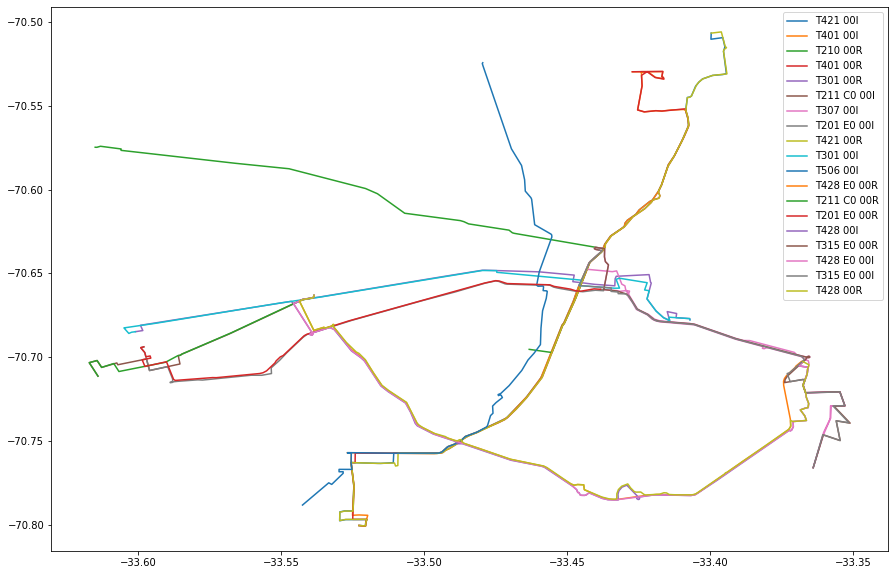

In [59]:
servs = train.Servicio.unique()
#servs = ['T301 00I']
plt.figure(figsize=(15,10))
for serv in servs:
    coord = shape.loc[shape.Servicio == serv]
    plt.plot(coord.Latitud, coord.Longitud)
    plt.legend(servs)
plt.show()

Se elige el recorrido T301 00I como referencia para calcular distancias o similitudes que permitan codificar en base a ellas.  

Como los .shape de distintos servicios tienen diferente cantidad de puntos de latitud y longitud, se utiliza el algoritmo de *Dynamic Time Warping* para hacer el cálculo de distancias y a partir de ellas deducir similitud.

In [86]:
#Codificación por similitud con respecto a T301 00I
#Recibe lista con nombres de servicios
#Retorna diccionario con codificación
def similarity_encoding(servs):
    encoding = {}
    N = len(servs)
    dist = lambda x1, x2: math.hypot(x2[0] - x1[0], x2[1] - x1[1])
    a = shape.loc[shape.Servicio == 'T301 00I']
    a = [tuple(x) for x in a[['Latitud','Longitud']].to_numpy()]
    for i in range(N):
        b = shape.loc[shape.Servicio == servs[i]]
        b = [tuple(x) for x in b[['Latitud','Longitud']].to_numpy()]
        d = dtw(a, b, dist=dist)[0]
        sim = 1/(1 + d)
        encoding[servs[i]] = sim
    return encoding

In [96]:
encoding_dict = similarity_encoding(servs)
encoding_dict

{'T201 E0 00I': 0.32673364644094705,
 'T201 E0 00R': 0.09725571297366113,
 'T210 00R': 0.09489176337738059,
 'T211 C0 00I': 0.15588591986876846,
 'T211 C0 00R': 0.11895475986141894,
 'T301 00I': 1.0,
 'T301 00R': 0.10000054692625993,
 'T307 00I': 0.076395462579757,
 'T315 E0 00I': 0.12019094325543561,
 'T315 E0 00R': 0.0910442968778553,
 'T401 00I': 0.061719472603243425,
 'T401 00R': 0.0804350677428519,
 'T421 00I': 0.05913330024506811,
 'T421 00R': 0.0748571198245724,
 'T428 00I': 0.0798195388810493,
 'T428 00R': 0.046577412753888374,
 'T428 E0 00I': 0.09014199657923358,
 'T428 E0 00R': 0.05837551337795402,
 'T506 00I': 0.07578600392506764}

In [101]:
with open('encoding1.pickle', 'wb') as handle:
    pickle.dump(encoding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('encoding1.pickle', 'rb') as handle:
#    b = pickle.load(handle)

Otro intento: codificación por similitud  

Se calcula la matriz de similitud entre los .shape de los servicios considerados. Se obtiene una generalización de one-hot encoding. Se prueba definiendo como codificación los valores propios de dicha matriz.

In [83]:
#Matriz de similitud usando Dynamic Time Warping para distancias
#Recibe lista con nombres de servicios
#Retorna matriz de similitud
def similarity_matrix_dtw(servs):    
    N = len(servs)
    sim_matrix = np.zeros((N, N))
    dist = lambda x1, x2: math.hypot(x2[0] - x1[0], x2[1] - x1[1])
    for i in range(N):
        for j in range(N):
            a = shape.loc[shape.Servicio == servs[i]]
            b = shape.loc[shape.Servicio == servs[j]]
            a = [tuple(x) for x in a[['Latitud','Longitud']].to_numpy()]
            b = [tuple(x) for x in b[['Latitud','Longitud']].to_numpy()]
            d = dtw(a, b, dist=dist)[0]
            sim_matrix[i,j] = 1/(1 + d)
    return sim_matrix

In [106]:
sim = similarity_matrix_dtw(servs)
sim

array([[1.        , 0.55356672, 0.06163839, 0.0382566 , 0.07793722,
        0.0471265 , 0.05371901, 0.05110603, 0.03643728, 0.0591333 ,
        0.18590762, 0.05896321, 0.05343186, 0.08158647, 0.04588737,
        0.05526926, 0.04776575, 0.07317057, 0.05431844],
       [0.55356672, 1.        , 0.06422639, 0.03920342, 0.08066606,
        0.04854525, 0.05432676, 0.05303561, 0.0372359 , 0.06171947,
        0.20432291, 0.05881073, 0.05506203, 0.08362036, 0.04644951,
        0.05613828, 0.04835911, 0.07552777, 0.05415905],
       [0.06163839, 0.06422639, 1.        , 0.08597006, 0.18733769,
        0.10185287, 0.05682206, 0.08830409, 0.07758824, 0.09489176,
        0.07105245, 0.07483504, 0.11555773, 0.1351043 , 0.0500738 ,
        0.08302099, 0.0531848 , 0.07890425, 0.06144829],
       [0.0382566 , 0.03920342, 0.08597006, 1.        , 0.06345847,
        0.05470419, 0.05487936, 0.08311592, 0.56983011, 0.08043507,
        0.04503786, 0.05184958, 0.04922601, 0.05381344, 0.05532114,
        0.075

In [107]:
w, v = np.linalg.eig(sim)
enc = {}
for i,serv in enumerate(servs):
    enc[serv] = w[i]

enc

{'T201 E0 00I': 0.44607582980434635,
 'T201 E0 00R': 0.6953918781685664,
 'T210 00R': 1.648681070387793,
 'T211 C0 00I': 0.0985959227634843,
 'T211 C0 00R': 0.6597600872890498,
 'T301 00I': 1.1663329775656357,
 'T301 00R': 1.463098518525512,
 'T307 00I': 0.2124871215628127,
 'T315 E0 00I': 0.8613648594273026,
 'T315 E0 00R': 0.8254848349631662,
 'T401 00I': 1.767476169940996,
 'T401 00R': 1.531905772432553,
 'T421 00I': 2.71791218108417,
 'T421 00R': 0.43007244760406305,
 'T428 00I': 0.9597312484779763,
 'T428 00R': 0.8718334690433821,
 'T428 E0 00I': 0.8876439093612328,
 'T428 E0 00R': 0.6042998661455319,
 'T506 00I': 1.151851835452427}

In [109]:
with open('encoding2.pickle', 'wb') as handle:
    pickle.dump(enc, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('encoding2.pickle', 'rb') as handle:
#    b = pickle.load(handle)